In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
import matplotlib.pyplot as pyplot

from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'
figdir = '/g/data/hh5/tmp/access-om/fbd581/basal_mom5-collaborative-project/figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41657,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:46069,Total threads: 4
Dashboard: /proxy/34679/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:40757,


In [3]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
# 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
control = '01deg_jra55v13_ryf9091_DSW'
master_session = cc.database.create_session(session_name)

# session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
      
# temperature of meltwater using Gade line:
basal_gade = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'
basal_gade_icb = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'
basal_nogade = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'

In [4]:
%%time
# Make sure these match the available restarts:
start_time='1900-01-01'
end_time='1910-12-31'

lat_slice  = slice(-80,-59)

# load surface heat flux from different components:
sfc_hflux_from_runoff = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_coupler = cc.querying.getvar(control, 'sfc_hflux_coupler', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_pme = cc.querying.getvar(control, 'sfc_hflux_pme', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
frazil_3d_int_z = cc.querying.getvar(control, 'frazil_3d_int_z', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
swflx = cc.querying.getvar(control, 'swflx', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
lw_heat = cc.querying.getvar(control, 'lw_heat', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sens_heat = cc.querying.getvar(control, 'sens_heat', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
evap_heat = cc.querying.getvar(control, 'evap_heat', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
fprec_melt_heat = cc.querying.getvar(control, 'fprec_melt_heat', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)

mhflux_ctrl = sfc_hflux_coupler - (swflx+lw_heat+sens_heat+evap_heat+fprec_melt_heat)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

CPU times: user 5.18 s, sys: 609 ms, total: 5.79 s
Wall time: 19.5 s


In [5]:
%%time

sfc_hflux_from_runoff_noBG = cc.querying.getvar(basal_nogade, 'sfc_hflux_from_runoff', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_coupler_noBG = cc.querying.getvar(basal_nogade, 'sfc_hflux_coupler', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_pme_noBG = cc.querying.getvar(basal_nogade, 'sfc_hflux_pme', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
frazil_3d_int_z_noBG = cc.querying.getvar(basal_nogade, 'frazil_3d_int_z', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
temp_basalmix_noBG = cc.querying.getvar(basal_nogade, 'temp_basalmix', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
temp_icbmix_noBG = cc.querying.getvar(basal_nogade, 'temp_icbmix', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
swflx_noBG = cc.querying.getvar(basal_nogade, 'swflx', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
lw_heat_noBG = cc.querying.getvar(basal_nogade, 'lw_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sens_heat_noBG = cc.querying.getvar(basal_nogade, 'sens_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
evap_heat_noBG = cc.querying.getvar(basal_nogade, 'evap_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
fprec_melt_heat_noBG = cc.querying.getvar(basal_nogade, 'fprec_melt_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)

mhflux_noBG = sfc_hflux_coupler_noBG - (swflx_noBG+lw_heat_noBG+sens_heat_noBG+evap_heat_noBG+fprec_melt_heat_noBG)

CPU times: user 13.4 s, sys: 955 ms, total: 14.3 s
Wall time: 25 s


In [6]:
%%time

sfc_hflux_from_runoff_BG = cc.querying.getvar(basal_gade, 'sfc_hflux_from_runoff', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_coupler_BG = cc.querying.getvar(basal_gade, 'sfc_hflux_coupler', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_pme_BG = cc.querying.getvar(basal_gade, 'sfc_hflux_pme', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
frazil_3d_int_z_BG = cc.querying.getvar(basal_gade, 'frazil_3d_int_z', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
temp_basalmix_BG = cc.querying.getvar(basal_gade, 'temp_basalmix', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
temp_icbmix_BG = cc.querying.getvar(basal_gade, 'temp_icbmix', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
swflx_BG = cc.querying.getvar(basal_gade, 'swflx', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
lw_heat_BG = cc.querying.getvar(basal_gade, 'lw_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sens_heat_BG = cc.querying.getvar(basal_gade, 'sens_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
evap_heat_BG = cc.querying.getvar(basal_gade, 'evap_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
fprec_melt_heat_BG = cc.querying.getvar(basal_gade, 'fprec_melt_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)

mhflux_BG = sfc_hflux_coupler_BG - (swflx_BG+lw_heat_BG+sens_heat_BG+evap_heat_BG+fprec_melt_heat_BG)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

CPU times: user 8.71 s, sys: 809 ms, total: 9.52 s
Wall time: 17.3 s


In [7]:
%%time
sfc_hflux_from_runoff_ICB = cc.querying.getvar(basal_gade_icb, 'sfc_hflux_from_runoff', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_coupler_ICB = cc.querying.getvar(basal_gade_icb, 'sfc_hflux_coupler', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_hflux_pme_ICB = cc.querying.getvar(basal_gade_icb, 'sfc_hflux_pme', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
frazil_3d_int_z_ICB = cc.querying.getvar(basal_gade_icb, 'frazil_3d_int_z', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
temp_basalmix_ICB = cc.querying.getvar(basal_gade_icb, 'temp_basalmix', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
temp_icbmix_ICB = cc.querying.getvar(basal_gade_icb, 'temp_icbmix', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
swflx_ICB = cc.querying.getvar(basal_gade_icb, 'swflx', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
lw_heat_ICB = cc.querying.getvar(basal_gade_icb, 'lw_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sens_heat_ICB = cc.querying.getvar(basal_gade_icb, 'sens_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
evap_heat_ICB = cc.querying.getvar(basal_gade_icb, 'evap_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
fprec_melt_heat_ICB = cc.querying.getvar(basal_gade_icb, 'fprec_melt_heat', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)

mhflux_ICB = sfc_hflux_coupler_ICB - (swflx_ICB+lw_heat_ICB+sens_heat_ICB+evap_heat_ICB+fprec_melt_heat_ICB)

CPU times: user 14.4 s, sys: 1.38 s, total: 15.8 s
Wall time: 25.9 s


In [8]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [9]:
%%time
import numpy.ma as ma

area_t = cc.querying.getvar(control,'area_t' , master_session,n=1).sel(yt_ocean=lat_slice)

# function to do annual avg and horiz. integral: ONLY SHELF
def var_tavg_hint_shelf(var2d):
    var = var2d.mean('time') # annual mean
    var_masked = ma.masked_where(ht > 1000, var) # masked offshore 1000m isobath
    var_masked_area = var_masked*area_t # multiply by area
    var_hint = np.nansum(np.nansum(var_masked_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

# function to do ONLY horiz. integral: ONLY SHELF
def var_hint_shelf(var2d):
    var_masked = ma.masked_where(ht > 1000, var2d) # masked offshore 1000m isobath
    var_masked_area = var_masked*area_t # multiply by area
    var_hint = np.nansum(np.nansum(var_masked_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

# function to do annual avg and horiz. integral: GLOBAL
def var_tavg_hint(var2d):
    var = var2d.mean('time') # annual mean
    var_area = var*area_t # multiply by area
    var_hint = np.nansum(np.nansum(var_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

CPU times: user 51.3 ms, sys: 10.9 ms, total: 62.2 ms
Wall time: 102 ms


In [10]:
%%time

# Control experiment:

# self-only
HF_runoff_annual_hint_shelf_ctrl = var_tavg_hint_shelf(sfc_hflux_from_runoff)
HF_coupler_annual_hint_shelf_ctrl = var_tavg_hint_shelf(sfc_hflux_coupler)
HF_pme_annual_hint_shelf_ctrl = var_tavg_hint_shelf(sfc_hflux_pme)
HF_frazil_annual_hint_shelf_ctrl = var_tavg_hint_shelf(frazil_3d_int_z)
HF_sw_annual_hint_shelf_ctrl = var_tavg_hint_shelf(swflx)
HF_lw_annual_hint_shelf_ctrl = var_tavg_hint_shelf(lw_heat)
HF_sens_annual_hint_shelf_ctrl = var_tavg_hint_shelf(sens_heat)
HF_evap_annual_hint_shelf_ctrl = var_tavg_hint_shelf(evap_heat)
HF_fprec_annual_hint_shelf_ctrl = var_tavg_hint_shelf(fprec_melt_heat)
HF_mh_annual_hint_shelf_ctrl = var_tavg_hint_shelf(mhflux_ctrl)

# global
# HF_runoff_annual_hint_ctrl = var_tavg_hint(sfc_hflux_from_runoff)
# HF_coupler_annual_hint_ctrl = var_tavg_hint(sfc_hflux_coupler)
# HF_pme_annual_hint_ctrl = var_tavg_hint(sfc_hflux_pme)
# HF_frazil_annual_hint_ctrl = var_tavg_hint(frazil_3d_int_z)
# HF_sw_annual_hint_ctrl = var_tavg_hint(swflx)
# HF_lw_annual_hint_ctrl = var_tavg_hint(lw_heat)
# HF_sens_annual_hint_ctrl = var_tavg_hint(sens_heat)
# HF_evap_annual_hint_ctrl = var_tavg_hint(evap_heat)
# HF_fprec_annual_hint_ctrl = var_tavg_hint(fprec_melt_heat)
# HF_mh_annual_hint_ctrl = var_tavg_hint(mhflux_ctrl)

CPU times: user 27.4 s, sys: 2.02 s, total: 29.4 s
Wall time: 40 s


In [11]:
%%time

# Basal_NOgade experiment:

# global
# HF_runoff_annual_hint_noBG = var_tavg_hint(sfc_hflux_from_runoff_noBG)
# HF_coupler_annual_hint_noBG = var_tavg_hint(sfc_hflux_coupler_noBG)
# HF_pme_annual_hint_noBG = var_tavg_hint(sfc_hflux_pme_noBG)
# HF_frazil_annual_hint_noBG = var_tavg_hint(frazil_3d_int_z_noBG)
# HF_sw_annual_hint_noBG = var_tavg_hint(swflx_noBG)
# HF_lw_annual_hint_noBG = var_tavg_hint(lw_heat_noBG)
# HF_sens_annual_hint_noBG = var_tavg_hint(sens_heat_noBG)
# HF_evap_annual_hint_noBG = var_tavg_hint(evap_heat_noBG)
# HF_fprec_annual_hint_noBG = var_tavg_hint(fprec_melt_heat_noBG)

# # first get vertical sum of basal and icb mix:
HF_basalmix_annual_vint_noBG = np.sum(temp_basalmix_noBG, axis=1)
HF_icbmix_annual_vint_noBG = np.sum(temp_icbmix_noBG, axis=1)

# HF_basalmix_annual_hint_noBG = var_tavg_hint(HF_basalmix_annual_vint_noBG)
# HF_icbmix_annual_hint_noBG = var_tavg_hint(HF_icbmix_annual_vint_noBG)
# HF_mh_annual_hint_noBG = var_tavg_hint(mhflux_noBG)

# shelf-only
HF_runoff_annual_hint_shelf_noBG = var_tavg_hint_shelf(sfc_hflux_from_runoff_noBG)
HF_coupler_annual_hint_shelf_noBG = var_tavg_hint_shelf(sfc_hflux_coupler_noBG)
HF_pme_annual_hint_shelf_noBG = var_tavg_hint_shelf(sfc_hflux_pme_noBG)
HF_frazil_annual_hint_shelf_noBG = var_tavg_hint_shelf(frazil_3d_int_z_noBG)
HF_sw_annual_hint_shelf_noBG = var_tavg_hint_shelf(swflx_noBG)
HF_lw_annual_hint_shelf_noBG = var_tavg_hint_shelf(lw_heat_noBG)
HF_sens_annual_hint_shelf_noBG = var_tavg_hint_shelf(sens_heat_noBG)
HF_evap_annual_hint_shelf_noBG = var_tavg_hint_shelf(evap_heat_noBG)
HF_fprec_annual_hint_shelf_noBG = var_tavg_hint_shelf(fprec_melt_heat_noBG)

HF_basalmix_annual_hint_shelf_noBG = var_tavg_hint_shelf(HF_basalmix_annual_vint_noBG)
HF_icbmix_annual_hint_shelf_noBG = var_tavg_hint_shelf(HF_icbmix_annual_vint_noBG)
HF_mh_annual_hint_shelf_noBG = var_tavg_hint_shelf(mhflux_noBG)

CPU times: user 4min 20s, sys: 8.12 s, total: 4min 28s
Wall time: 4min 48s


In [12]:
%%time

# Basal_gade experiment:

# global
# HF_runoff_annual_hint_BG = var_tavg_hint(sfc_hflux_from_runoff_BG)
# HF_coupler_annual_hint_BG = var_tavg_hint(sfc_hflux_coupler_BG)
# HF_pme_annual_hint_BG = var_tavg_hint(sfc_hflux_pme_BG)
# HF_frazil_annual_hint_BG = var_tavg_hint(frazil_3d_int_z_BG)
# HF_sw_annual_hint_BG = var_tavg_hint(swflx_BG)
# HF_lw_annual_hint_BG = var_tavg_hint(lw_heat_BG)
# HF_sens_annual_hint_BG = var_tavg_hint(sens_heat_BG)
# HF_evap_annual_hint_BG = var_tavg_hint(evap_heat_BG)
# HF_fprec_annual_hint_BG = var_tavg_hint(fprec_melt_heat_BG)

# # first get vertical sum of basal and icb mix:
HF_basalmix_annual_vint_BG = np.sum(temp_basalmix_BG, axis=1)
HF_icbmix_annual_vint_BG = np.sum(temp_icbmix_BG, axis=1)

# HF_basalmix_annual_hint_BG = var_tavg_hint(HF_basalmix_annual_vint_BG)
# HF_icbmix_annual_hint_BG = var_tavg_hint(HF_icbmix_annual_vint_BG)
# HF_mh_annual_hint_BG = var_tavg_hint(mhflux_BG)

# shelf-only
HF_runoff_annual_hint_shelf_BG = var_tavg_hint_shelf(sfc_hflux_from_runoff_BG)
HF_coupler_annual_hint_shelf_BG = var_tavg_hint_shelf(sfc_hflux_coupler_BG)
HF_pme_annual_hint_shelf_BG = var_tavg_hint_shelf(sfc_hflux_pme_BG)
HF_frazil_annual_hint_shelf_BG = var_tavg_hint_shelf(frazil_3d_int_z_BG)
HF_sw_annual_hint_shelf_BG = var_tavg_hint_shelf(swflx_BG)
HF_lw_annual_hint_shelf_BG = var_tavg_hint_shelf(lw_heat_BG)
HF_sens_annual_hint_shelf_BG = var_tavg_hint_shelf(sens_heat_BG)
HF_evap_annual_hint_shelf_BG = var_tavg_hint_shelf(evap_heat_BG)
HF_fprec_annual_hint_shelf_BG = var_tavg_hint_shelf(fprec_melt_heat_BG)

HF_basalmix_annual_hint_shelf_BG = var_tavg_hint_shelf(HF_basalmix_annual_vint_BG)
HF_icbmix_annual_hint_shelf_BG = var_tavg_hint_shelf(HF_icbmix_annual_vint_BG)
HF_mh_annual_hint_shelf_BG = var_tavg_hint_shelf(mhflux_BG)

CPU times: user 4min 13s, sys: 8.5 s, total: 4min 22s
Wall time: 4min 38s


In [13]:
%%time

# Basal+Iceberg experiment:

# global
# HF_runoff_annual_hint_ICB = var_tavg_hint(sfc_hflux_from_runoff_ICB)
# HF_coupler_annual_hint_ICB = var_tavg_hint(sfc_hflux_coupler_ICB)
# HF_pme_annual_hint_ICB = var_tavg_hint(sfc_hflux_pme_ICB)
# HF_frazil_annual_hint_ICB = var_tavg_hint(frazil_3d_int_z_ICB)
# HF_sw_annual_hint_ICB = var_tavg_hint(swflx_ICB)
# HF_lw_annual_hint_ICB = var_tavg_hint(lw_heat_ICB)
# HF_sens_annual_hint_ICB = var_tavg_hint(sens_heat_ICB)
# HF_evap_annual_hint_ICB = var_tavg_hint(evap_heat_ICB)
# HF_fprec_annual_hint_ICB = var_tavg_hint(fprec_melt_heat_ICB)

# # first get vertical sum of basal and icb mix:
HF_basalmix_annual_vint_ICB = np.sum(temp_basalmix_ICB, axis=1)
HF_icbmix_annual_vint_ICB = np.sum(temp_icbmix_ICB, axis=1)

# HF_basalmix_annual_hint_ICB = var_tavg_hint(HF_basalmix_annual_vint_ICB)
# HF_icbmix_annual_hint_ICB = var_tavg_hint(HF_icbmix_annual_vint_ICB)
# HF_mh_annual_hint_ICB = var_tavg_hint(mhflux_ICB)

# shelf-only
HF_runoff_annual_hint_shelf_ICB = var_tavg_hint_shelf(sfc_hflux_from_runoff_ICB)
HF_coupler_annual_hint_shelf_ICB = var_tavg_hint_shelf(sfc_hflux_coupler_ICB)
HF_pme_annual_hint_shelf_ICB = var_tavg_hint_shelf(sfc_hflux_pme_ICB)
HF_frazil_annual_hint_shelf_ICB = var_tavg_hint_shelf(frazil_3d_int_z_ICB)
HF_sw_annual_hint_shelf_ICB = var_tavg_hint_shelf(swflx_ICB)
HF_lw_annual_hint_shelf_ICB = var_tavg_hint_shelf(lw_heat_ICB)
HF_sens_annual_hint_shelf_ICB = var_tavg_hint_shelf(sens_heat_ICB)
HF_evap_annual_hint_shelf_ICB = var_tavg_hint_shelf(evap_heat_ICB)
HF_fprec_annual_hint_shelf_ICB = var_tavg_hint_shelf(fprec_melt_heat_ICB)

HF_basalmix_annual_hint_shelf_ICB = var_tavg_hint_shelf(HF_basalmix_annual_vint_ICB)
HF_icbmix_annual_hint_shelf_ICB = var_tavg_hint_shelf(HF_icbmix_annual_vint_ICB)
HF_mh_annual_hint_shelf_ICB = var_tavg_hint_shelf(mhflux_ICB)


CPU times: user 4min 32s, sys: 8.47 s, total: 4min 41s
Wall time: 5min 2s


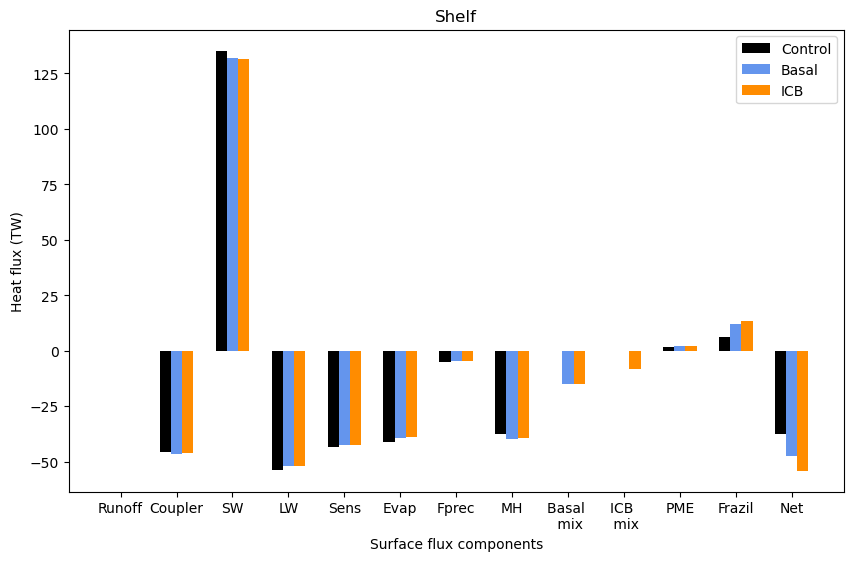

In [14]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,6))

pyplot.bar(-.2, HF_runoff_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k', label='Control')
pyplot.bar(0, HF_runoff_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(0.2, HF_runoff_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange', label='ICB')

plt.legend()

pyplot.bar(.8, HF_coupler_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k', label='Control')
pyplot.bar(1, HF_coupler_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(1.2, HF_coupler_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange', label='ICB')

pyplot.bar(1.8, HF_sw_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(2, HF_sw_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(2.2, HF_sw_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(2.8, HF_lw_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(3, HF_lw_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(3.2, HF_lw_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(3.8, HF_sens_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(4, HF_sens_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(4.2, HF_sens_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(4.8, HF_evap_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(5, HF_evap_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(5.2, HF_evap_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(5.8, HF_fprec_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(6, HF_fprec_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(6.2, HF_fprec_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(6.8, HF_mh_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(7, HF_mh_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(7.2, HF_mh_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(8, HF_basalmix_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(8.2, HF_basalmix_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(9, HF_icbmix_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(9.2, HF_icbmix_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(9.8, HF_pme_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(10, HF_pme_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(10.2, HF_pme_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

pyplot.bar(10.8, HF_frazil_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(11, HF_frazil_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(11.2, HF_frazil_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

# calculate NET SHF:
HF_net_annual_hint_shelf_ctrl = HF_runoff_annual_hint_shelf_ctrl+HF_coupler_annual_hint_shelf_ctrl+\
    HF_pme_annual_hint_shelf_ctrl+HF_frazil_annual_hint_shelf_ctrl

HF_net_annual_hint_shelf_BG = HF_runoff_annual_hint_shelf_BG+HF_coupler_annual_hint_shelf_BG+\
    HF_pme_annual_hint_shelf_BG+HF_frazil_annual_hint_shelf_BG+HF_basalmix_annual_hint_shelf_BG+HF_icbmix_annual_hint_shelf_BG

HF_net_annual_hint_shelf_ICB = HF_runoff_annual_hint_shelf_ICB+HF_coupler_annual_hint_shelf_ICB+\
    HF_pme_annual_hint_shelf_ICB+HF_frazil_annual_hint_shelf_ICB+HF_basalmix_annual_hint_shelf_ICB+HF_icbmix_annual_hint_shelf_ICB

pyplot.bar(11.8, HF_net_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(12, HF_net_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(12.2, HF_net_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')

ax.set_xticks(np.arange(0,13),('Runoff','Coupler','SW','LW','Sens','Evap','Fprec','MH','Basal \n mix','ICB \n mix','PME','Frazil','Net'))
# ax.set_xticks(np.arange(1,6),('Runoff','Basal mix','ICB mix','PME','Frazil'))#,'MH'))
ax.set_xlabel('Surface flux components')
ax.set_ylabel('Heat flux (TW)')

plt.title('Shelf')

### Save fig
plt.savefig(figdir+'SHF_components_annual_hint_shelf_yr10.png')

In [15]:
# print(HF_net_annual_hint_shelf_ctrl*1e-12, HF_net_annual_hint_shelf_noBG*1e-12, HF_net_annual_hint_shelf_BG*1e-12, HF_net_annual_hint_shelf_ICB*1e-12)

In [17]:
print(' --- NET ---')
print('Control = ', HF_net_annual_hint_shelf_ctrl*1e-12)
print('BG = ', HF_net_annual_hint_shelf_BG*1e-12)
print('ICB = ', HF_net_annual_hint_shelf_ICB*1e-12)
print('noBG = ', HF_net_annual_hint_shelf_noBG*1e-12)

print(' --- RUNOFF ---')
print('Control = ', HF_runoff_annual_hint_shelf_ctrl*1e-12)
print('BG = ', HF_runoff_annual_hint_shelf_BG*1e-12)
print('ICB = ', HF_runoff_annual_hint_shelf_ICB*1e-12)
print('noBG = ', HF_runoff_annual_hint_shelf_noBG*1e-12)

print(' --- COUPLER ---')
print('Control = ', HF_coupler_annual_hint_shelf_ctrl*1e-12)
print('BG = ', HF_coupler_annual_hint_shelf_BG*1e-12)
print('ICB = ', HF_coupler_annual_hint_shelf_ICB*1e-12)
print('noBG = ', HF_coupler_annual_hint_shelf_noBG*1e-12)

print(' --- SEA-ICE ---')
print('Control = ', HF_mh_annual_hint_shelf_ctrl*1e-12)
print('BG = ', HF_mh_annual_hint_shelf_BG*1e-12)
print('ICB = ', HF_mh_annual_hint_shelf_ICB*1e-12)
print('noBG = ', HF_mh_annual_hint_shelf_noBG*1e-12)

print(' --- BASAL/ICB MIX ---')
print('BG = ', (HF_basalmix_annual_hint_shelf_BG+HF_icbmix_annual_hint_shelf_BG)*1e-12)
print('ICB = ', (HF_basalmix_annual_hint_shelf_ICB+HF_icbmix_annual_hint_shelf_ICB)*1e-12)
print('noBG = ', (HF_basalmix_annual_hint_shelf_noBG+HF_icbmix_annual_hint_shelf_noBG)*1e-12)

print(' --- PME ---')
print('Control = ', HF_pme_annual_hint_shelf_ctrl*1e-12)
print('BG = ', HF_pme_annual_hint_shelf_BG*1e-12)
print('ICB = ', HF_pme_annual_hint_shelf_ICB*1e-12)
print('noBG = ', HF_pme_annual_hint_shelf_noBG*1e-12)

print(' --- FRAZIL ---')
print('Control = ', HF_frazil_annual_hint_shelf_ctrl*1e-12)
print('BG = ', HF_frazil_annual_hint_shelf_BG*1e-12)
print('ICB = ', HF_frazil_annual_hint_shelf_ICB*1e-12)
print('noBG = ', HF_frazil_annual_hint_shelf_noBG*1e-12)

 --- NET ---
Control =  -37.350369394688
BG =  -47.513654525952
ICB =  -54.029648396287996
noBG =  -39.098391724032
 --- RUNOFF ---
Control =  0.050755076095999996
BG =  0.01198947328
ICB =  0.0
noBG =  0.016726016
 --- COUPLER ---
Control =  -45.460244922368
BG =  -46.63579508736
ICB =  -46.126577221632
noBG =  -46.848144310272
 --- SEA-ICE ---
Control =  -37.546037870592
BG =  -39.666820579328
ICB =  -39.458749546496
noBG =  -36.377047597056
 --- BASAL/ICB MIX ---
BG =  -15.2041422848
ICB =  -23.24584988672
noBG =  0.0
 --- PME ---
Control =  1.7284857856
BG =  2.099380092928
ICB =  2.137681690624
noBG =  1.702958727168
 --- FRAZIL ---
Control =  6.3306370908159995
BG =  12.214910058495999
ICB =  13.205099249664
noBG =  6.030067499008


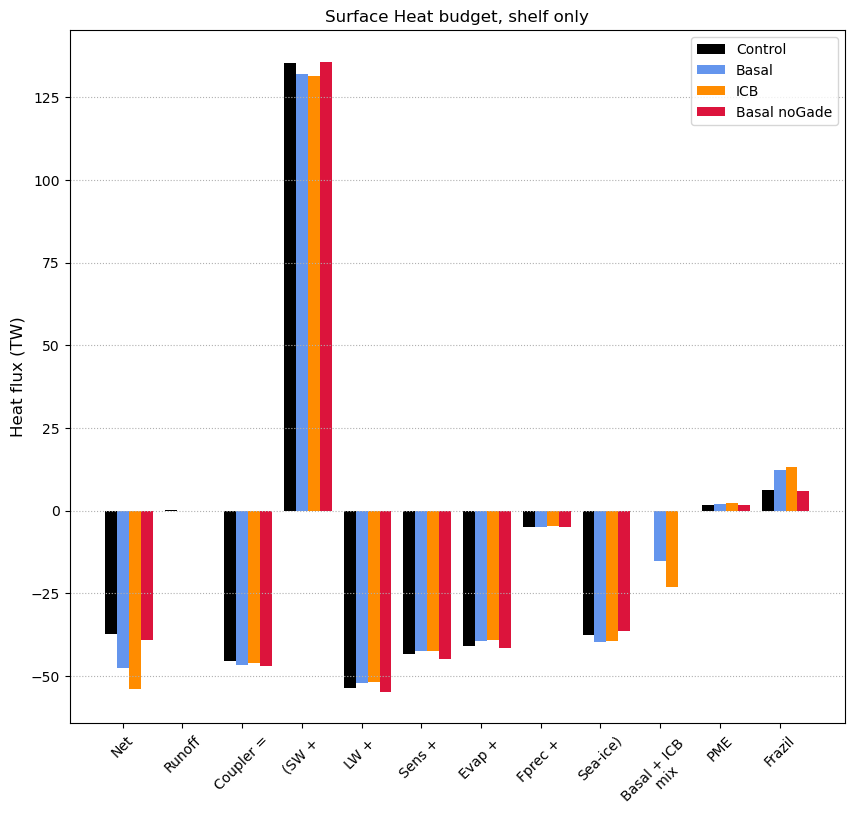

In [25]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,9))

pyplot.bar(.8, HF_runoff_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k', label='Control')
pyplot.bar(1.0, HF_runoff_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(1.2, HF_runoff_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange', label='ICB')
pyplot.bar(1.4, HF_runoff_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson', label='Basal noGade')

plt.legend()

pyplot.bar(1.8, HF_coupler_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k', label='Control')
pyplot.bar(2, HF_coupler_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(2.2, HF_coupler_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange', label='ICB')
pyplot.bar(2.4, HF_coupler_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson', label='Basal noGade')

pyplot.bar(2.8, HF_sw_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(3, HF_sw_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(3.2, HF_sw_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(3.4, HF_sw_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(3.8, HF_lw_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(4, HF_lw_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(4.2, HF_lw_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(4.4, HF_lw_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(4.8, HF_sens_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(5, HF_sens_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(5.2, HF_sens_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(5.4, HF_sens_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(5.8, HF_evap_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(6, HF_evap_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(6.2, HF_evap_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(6.4, HF_evap_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(6.8, HF_fprec_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(7, HF_fprec_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(7.2, HF_fprec_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(7.4, HF_fprec_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(7.8, HF_mh_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(8, HF_mh_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(8.2, HF_mh_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(8.4, HF_mh_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(9, (HF_basalmix_annual_hint_shelf_BG+HF_icbmix_annual_hint_shelf_BG)*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(9.2, (HF_basalmix_annual_hint_shelf_ICB+HF_icbmix_annual_hint_shelf_ICB)*1e-12, width=0.2, color='darkorange')
pyplot.bar(9.4, (HF_basalmix_annual_hint_shelf_noBG+HF_icbmix_annual_hint_shelf_noBG)*1e-12, width=0.2, color='crimson')

pyplot.bar(9.8, HF_pme_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(10.0, HF_pme_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(10.2, HF_pme_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(10.4, HF_pme_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(10.8, HF_frazil_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(11, HF_frazil_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(11.2, HF_frazil_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(11.4, HF_frazil_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

# calculate NET SHF:
HF_net_annual_hint_shelf_ctrl = HF_runoff_annual_hint_shelf_ctrl+HF_coupler_annual_hint_shelf_ctrl+\
            HF_pme_annual_hint_shelf_ctrl+HF_frazil_annual_hint_shelf_ctrl
HF_net_annual_hint_shelf_noBG = HF_runoff_annual_hint_shelf_noBG+HF_coupler_annual_hint_shelf_noBG+\
            HF_pme_annual_hint_shelf_noBG+HF_frazil_annual_hint_shelf_noBG+\
            HF_basalmix_annual_hint_shelf_noBG+HF_icbmix_annual_hint_shelf_noBG
HF_net_annual_hint_shelf_BG = HF_runoff_annual_hint_shelf_BG+HF_coupler_annual_hint_shelf_BG+\
            HF_pme_annual_hint_shelf_BG+HF_frazil_annual_hint_shelf_BG+\
            HF_basalmix_annual_hint_shelf_BG+HF_icbmix_annual_hint_shelf_BG
HF_net_annual_hint_shelf_ICB = HF_runoff_annual_hint_shelf_ICB+HF_coupler_annual_hint_shelf_ICB+\
            HF_pme_annual_hint_shelf_ICB+HF_frazil_annual_hint_shelf_ICB+\
            HF_basalmix_annual_hint_shelf_ICB+HF_icbmix_annual_hint_shelf_ICB

pyplot.bar(-.2, HF_net_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(0, HF_net_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(.2, HF_net_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
pyplot.bar(.4, HF_net_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

ax.set_xticks(np.arange(0,12),('Net','Runoff','Coupler =','(SW + ','LW + ','Sens + ','Evap + ','Fprec + ','Sea-ice)','Basal + ICB \n mix','PME','Frazil'), rotation=45) 
# ax.set_xlabel('Surface flux components')
ax.set_ylabel('Heat flux (TW)',fontsize=12)
plt.title('Surface Heat budget, shelf only')
ax.yaxis.grid(True, linestyle=':')

### Save fig
plt.savefig(figdir+'SHF_components_annual_hint_shelf_yr10_FinalFig.png')

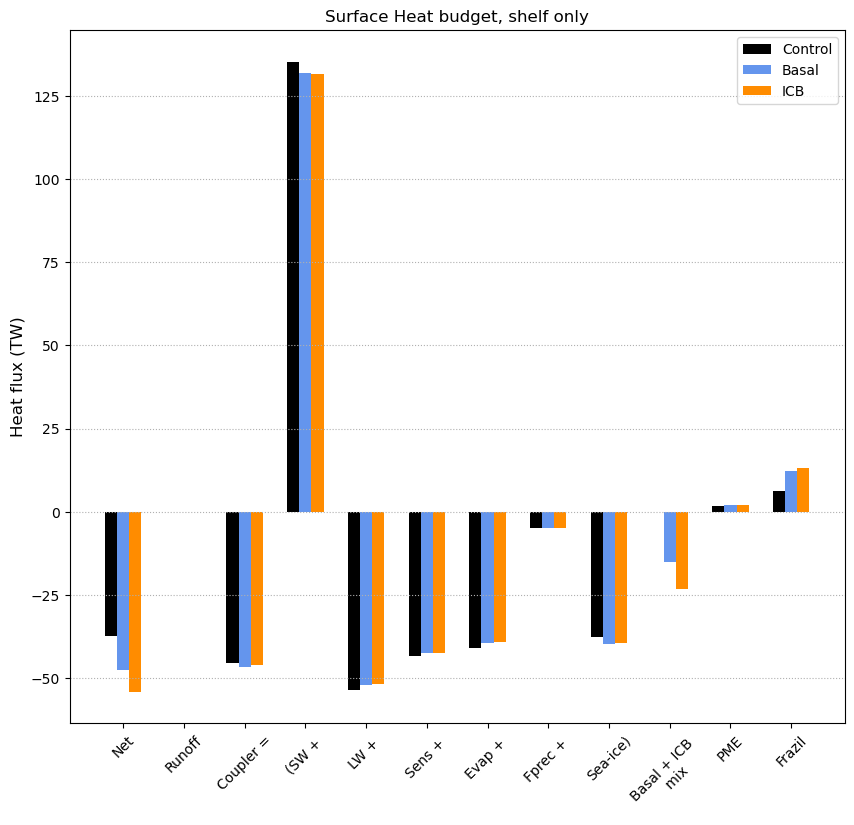

In [24]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,9))

pyplot.bar(.8, HF_runoff_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k', label='Control')
pyplot.bar(1.0, HF_runoff_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(1.2, HF_runoff_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange', label='ICB')
# pyplot.bar(1.4, HF_runoff_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson', label='Basal noGade')

plt.legend()

pyplot.bar(1.8, HF_coupler_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k', label='Control')
pyplot.bar(2, HF_coupler_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(2.2, HF_coupler_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange', label='ICB')
# pyplot.bar(2.4, HF_coupler_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson', label='Basal noGade')

pyplot.bar(2.8, HF_sw_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(3, HF_sw_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(3.2, HF_sw_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(3.4, HF_sw_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(3.8, HF_lw_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(4, HF_lw_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(4.2, HF_lw_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(4.4, HF_lw_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(4.8, HF_sens_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(5, HF_sens_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(5.2, HF_sens_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(5.4, HF_sens_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(5.8, HF_evap_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(6, HF_evap_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(6.2, HF_evap_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(6.4, HF_evap_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(6.8, HF_fprec_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(7, HF_fprec_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(7.2, HF_fprec_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(7.4, HF_fprec_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(7.8, HF_mh_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(8, HF_mh_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(8.2, HF_mh_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(8.4, HF_mh_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(9, (HF_basalmix_annual_hint_shelf_BG+HF_icbmix_annual_hint_shelf_BG)*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(9.2, (HF_basalmix_annual_hint_shelf_ICB+HF_icbmix_annual_hint_shelf_ICB)*1e-12, width=0.2, color='darkorange')
# pyplot.bar(9.4, (HF_basalmix_annual_hint_shelf_noBG+HF_icbmix_annual_hint_shelf_noBG)*1e-12, width=0.2, color='crimson')

pyplot.bar(9.8, HF_pme_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(10.0, HF_pme_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(10.2, HF_pme_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(10.4, HF_pme_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

pyplot.bar(10.8, HF_frazil_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(11, HF_frazil_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(11.2, HF_frazil_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(11.4, HF_frazil_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

# calculate NET SHF:
HF_net_annual_hint_shelf_ctrl = HF_runoff_annual_hint_shelf_ctrl+HF_coupler_annual_hint_shelf_ctrl+\
            HF_pme_annual_hint_shelf_ctrl+HF_frazil_annual_hint_shelf_ctrl
HF_net_annual_hint_shelf_noBG = HF_runoff_annual_hint_shelf_noBG+HF_coupler_annual_hint_shelf_noBG+\
            HF_pme_annual_hint_shelf_noBG+HF_frazil_annual_hint_shelf_noBG+\
            HF_basalmix_annual_hint_shelf_noBG+HF_icbmix_annual_hint_shelf_noBG
HF_net_annual_hint_shelf_BG = HF_runoff_annual_hint_shelf_BG+HF_coupler_annual_hint_shelf_BG+\
            HF_pme_annual_hint_shelf_BG+HF_frazil_annual_hint_shelf_BG+\
            HF_basalmix_annual_hint_shelf_BG+HF_icbmix_annual_hint_shelf_BG
HF_net_annual_hint_shelf_ICB = HF_runoff_annual_hint_shelf_ICB+HF_coupler_annual_hint_shelf_ICB+\
            HF_pme_annual_hint_shelf_ICB+HF_frazil_annual_hint_shelf_ICB+\
            HF_basalmix_annual_hint_shelf_ICB+HF_icbmix_annual_hint_shelf_ICB

pyplot.bar(-.2, HF_net_annual_hint_shelf_ctrl*1e-12, width=0.2, color='k')
pyplot.bar(0, HF_net_annual_hint_shelf_BG*1e-12, width=0.2, color='cornflowerblue')
pyplot.bar(.2, HF_net_annual_hint_shelf_ICB*1e-12, width=0.2, color='darkorange')
# pyplot.bar(.4, HF_net_annual_hint_shelf_noBG*1e-12, width=0.2, color='crimson')

ax.set_xticks(np.arange(0,12),('Net','Runoff','Coupler =','(SW + ','LW + ','Sens + ','Evap + ','Fprec + ','Sea-ice)','Basal + ICB \n mix','PME','Frazil'), rotation=45) 
# ax.set_xlabel('Surface flux components')
ax.set_ylabel('Heat flux (TW)',fontsize=12)
plt.title('Surface Heat budget, shelf only')
ax.yaxis.grid(True, linestyle=':')

### Save fig
plt.savefig(figdir+'SHF_components_annual_hint_shelf_yr10_FinalFig_WO_noBG.png')

Text(0.5, 1.0, 'Shelf')

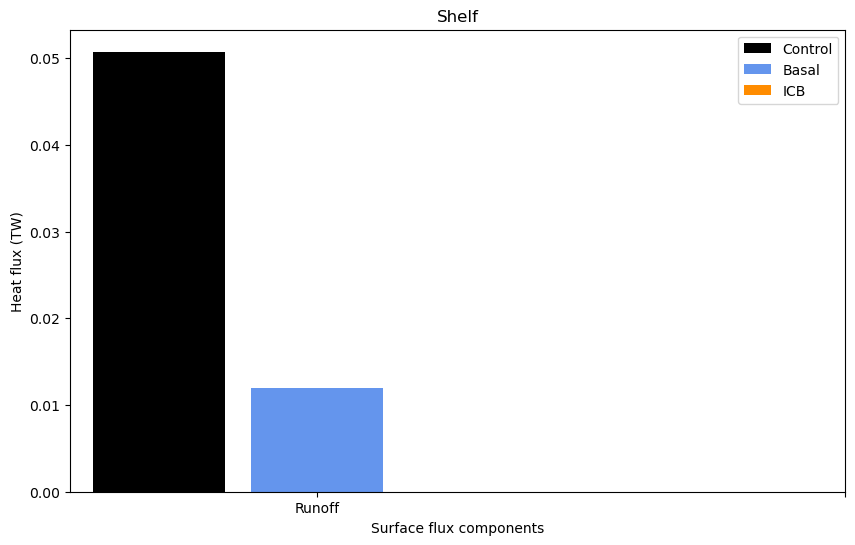

In [17]:
fig, ax  = plt.subplots(figsize = (10,6))
pyplot.bar(-.3, HF_runoff_annual_hint_shelf_ctrl*1e-12, width=0.25, color='k', label='Control')
pyplot.bar(0, HF_runoff_annual_hint_shelf_BG*1e-12, width=0.25, color='cornflowerblue', label='Basal')
pyplot.bar(0.3, HF_runoff_annual_hint_shelf_ICB*1e-12, width=0.25, color='darkorange', label='ICB')

# pyplot.bar(1., HF_basalmix_annual_hint_shelf_BG*1e-12, width=0.25, color='cornflowerblue')
# pyplot.bar(1.3, HF_basalmix_annual_hint_shelf_ICB*1e-12, width=0.25, color='darkorange')

# pyplot.bar(2, HF_icbmix_annual_hint_shelf_BG*1e-12, width=0.25, color='cornflowerblue')
# pyplot.bar(2.3, HF_icbmix_annual_hint_shelf_ICB*1e-12, width=0.25, color='darkorange')

ax.set_xticks(np.arange(0,2),('Runoff',''))
plt.legend()
ax.set_xlabel('Surface flux components')
ax.set_ylabel('Heat flux (TW)')

plt.title('Shelf')


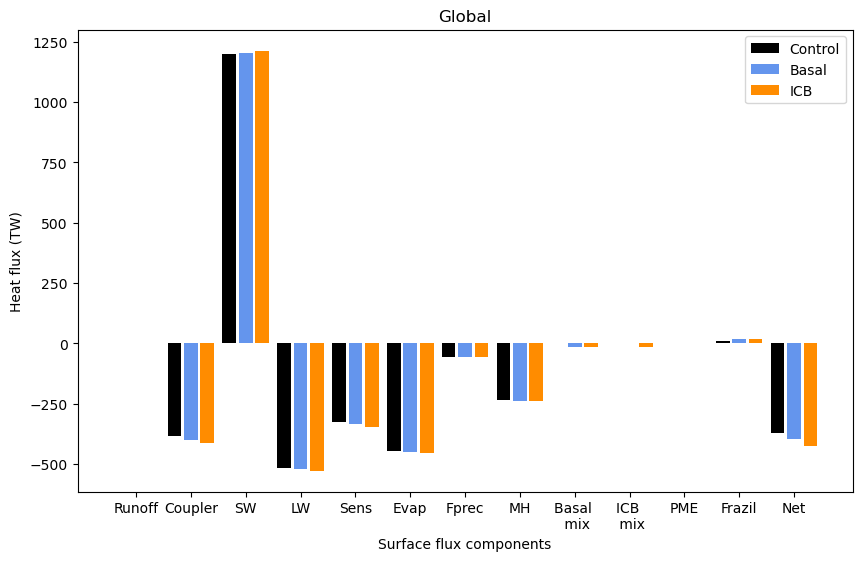

In [18]:
# plot with bars: last year annual avg, horizontal integrated (global):
fig, ax  = plt.subplots(figsize = (10,6))

pyplot.bar(-.3, HF_runoff_annual_hint_ctrl*1e-12, width=0.25, color='k', label='Control')
pyplot.bar(0, HF_runoff_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue', label='Basal')
pyplot.bar(0.3, HF_runoff_annual_hint_ICB*1e-12, width=0.25, color='darkorange', label='ICB')

plt.legend()

pyplot.bar(.7, HF_coupler_annual_hint_ctrl*1e-12, width=0.25, color='k', label='Control')
pyplot.bar(1, HF_coupler_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue', label='Basal')
pyplot.bar(1.3, HF_coupler_annual_hint_ICB*1e-12, width=0.25, color='darkorange', label='ICB')

pyplot.bar(1.7, HF_sw_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(2, HF_sw_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(2.3, HF_sw_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(2.7, HF_lw_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(3, HF_lw_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(3.3, HF_lw_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(3.7, HF_sens_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(4, HF_sens_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(4.3, HF_sens_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(4.7, HF_evap_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(5, HF_evap_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(5.3, HF_evap_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(5.7, HF_fprec_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(6, HF_fprec_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(6.3, HF_fprec_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(6.7, HF_mh_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(7, HF_mh_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(7.3, HF_mh_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(8, HF_basalmix_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(8.3, HF_basalmix_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(9, HF_icbmix_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(9.3, HF_icbmix_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(9.7, HF_pme_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(10, HF_pme_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(10.3, HF_pme_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

pyplot.bar(10.7, HF_frazil_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(11, HF_frazil_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(11.3, HF_frazil_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

# calculate NET SHF:
HF_net_annual_hint_ctrl = HF_runoff_annual_hint_ctrl+HF_coupler_annual_hint_ctrl+HF_pme_annual_hint_ctrl+HF_frazil_annual_hint_ctrl
HF_net_annual_hint_BG = HF_runoff_annual_hint_BG+HF_coupler_annual_hint_BG+HF_pme_annual_hint_BG+HF_frazil_annual_hint_BG+HF_basalmix_annual_hint_BG+HF_icbmix_annual_hint_BG
HF_net_annual_hint_ICB = HF_runoff_annual_hint_ICB+HF_coupler_annual_hint_ICB+HF_pme_annual_hint_ICB+HF_frazil_annual_hint_ICB+HF_basalmix_annual_hint_ICB+HF_icbmix_annual_hint_ICB

pyplot.bar(11.7, HF_net_annual_hint_ctrl*1e-12, width=0.25, color='k')
pyplot.bar(12, HF_net_annual_hint_BG*1e-12, width=0.25, color='cornflowerblue')
pyplot.bar(12.3, HF_net_annual_hint_ICB*1e-12, width=0.25, color='darkorange')

ax.set_xticks(np.arange(0,13),('Runoff','Coupler','SW','LW','Sens','Evap','Fprec','MH','Basal \n mix','ICB \n mix','PME','Frazil','Net'))
# ax.set_xticks(np.arange(1,6),('Runoff','Basal mix','ICB mix','PME','Frazil'))#,'MH'))
ax.set_xlabel('Surface flux components')
ax.set_ylabel('Heat flux (TW)')

plt.title('Global')

### Save fig
plt.savefig(figdir+'SHF_components_annual_hint_yr10.png')

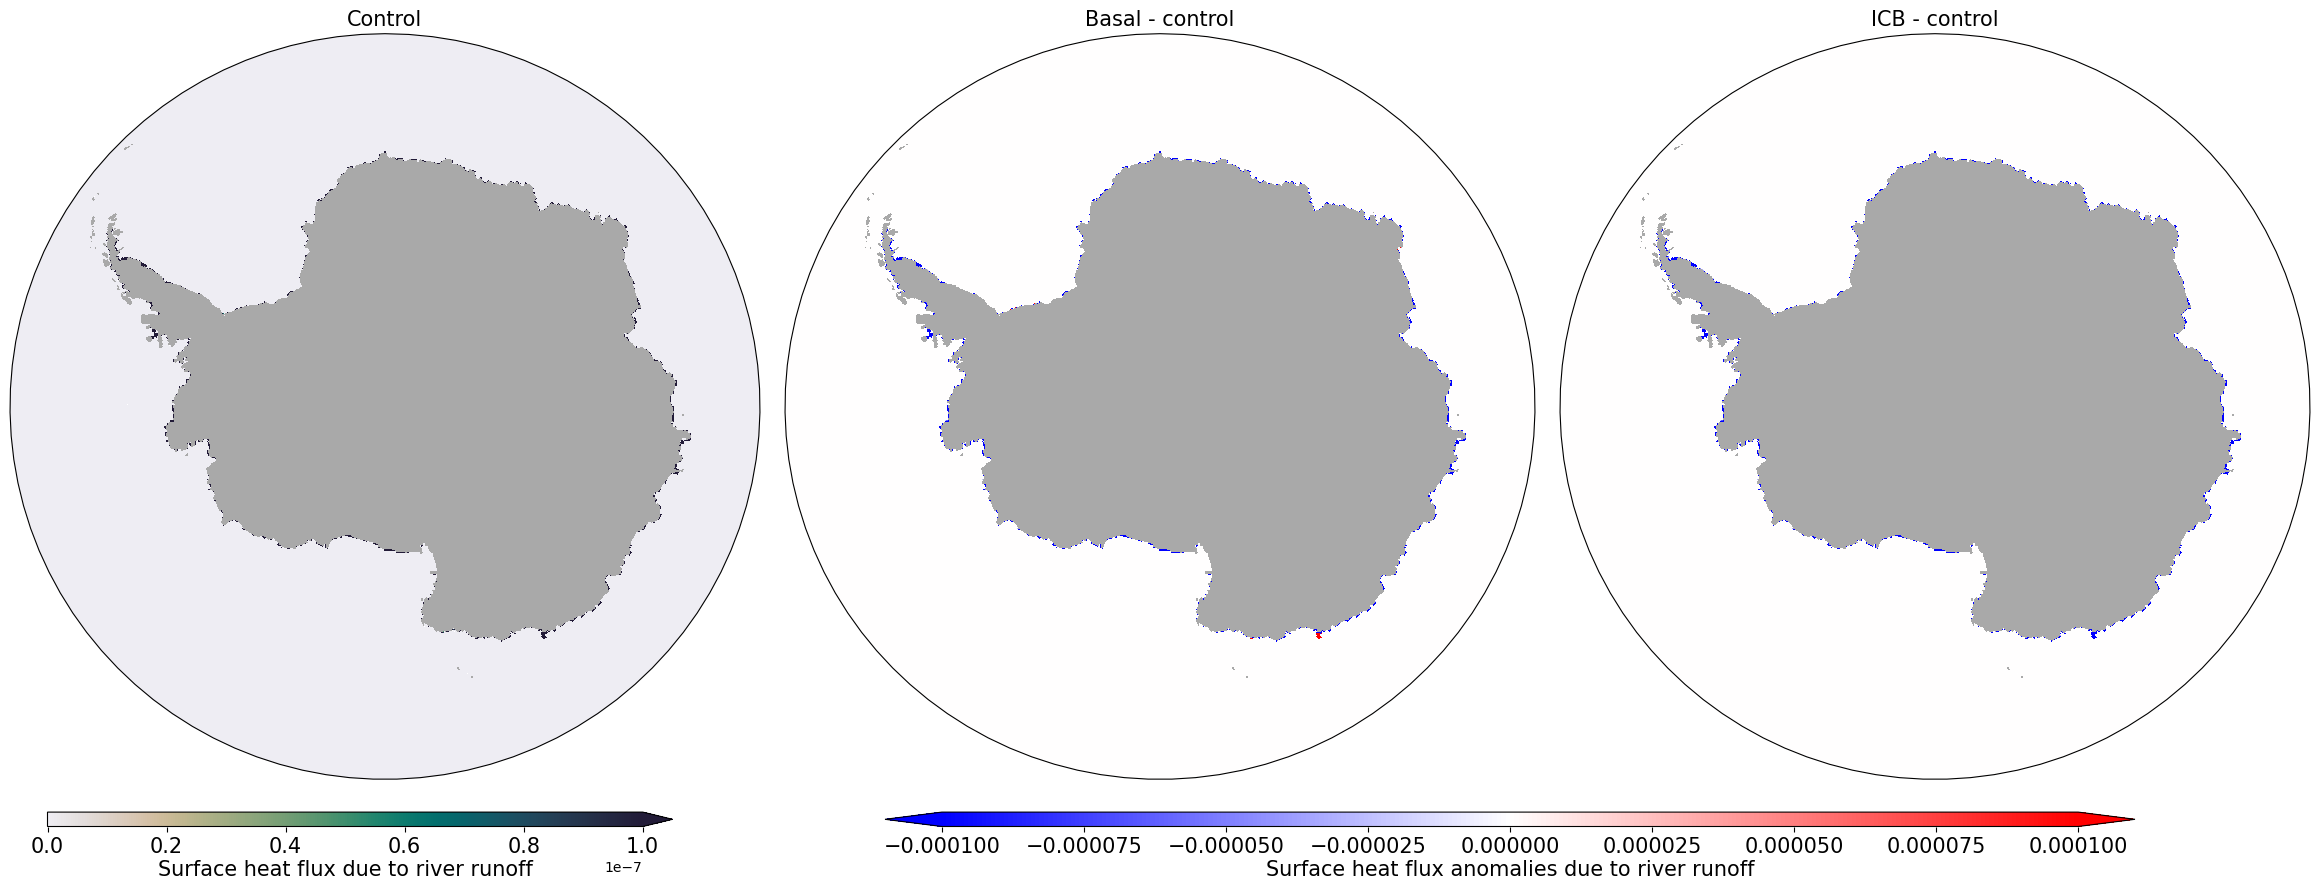

In [35]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=0.
rmax=1e-7

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(sfc_hflux_from_runoff.xt_ocean, sfc_hflux_from_runoff.yt_ocean, sfc_hflux_from_runoff.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-1e-4
rmax=1e-4

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(sfc_hflux_from_runoff_BG.xt_ocean, sfc_hflux_from_runoff_BG.yt_ocean, sfc_hflux_from_runoff_BG.mean('time')*area_t - sfc_hflux_from_runoff.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(sfc_hflux_from_runoff_ICB.xt_ocean, sfc_hflux_from_runoff_ICB.yt_ocean, sfc_hflux_from_runoff_ICB.mean('time')*area_t - sfc_hflux_from_runoff.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
# cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5]) #
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface heat flux due to river runoff',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface heat flux anomalies due to river runoff',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'sfc_hflux_runoff_anom_y'+str(year)+'.png')

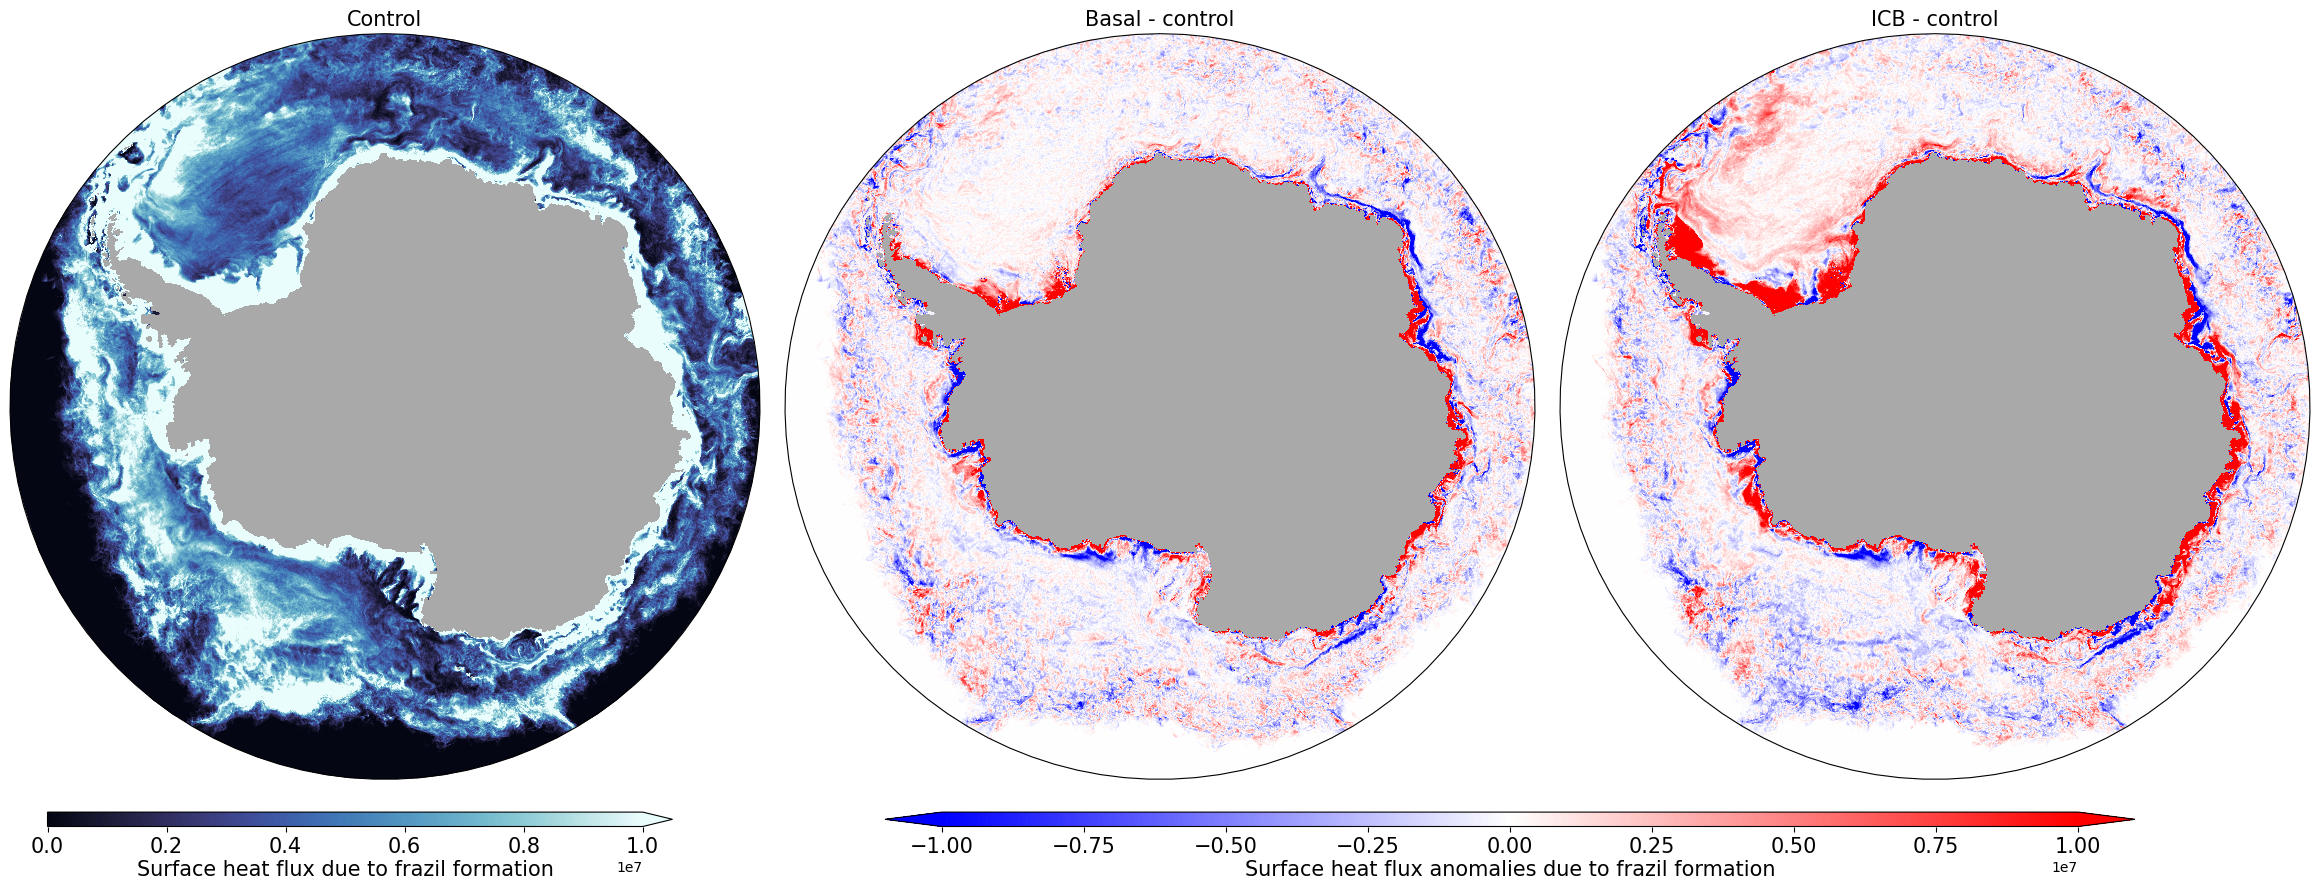

In [36]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=0.
rmax=1e7

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(frazil_3d_int_z.xt_ocean, frazil_3d_int_z.yt_ocean, frazil_3d_int_z.mean('time')*area_t, #norm = norm,
    cmap = cmocean.ice, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# anomalies below:
rmin=-1e7
rmax=1e7

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(frazil_3d_int_z_BG.xt_ocean, frazil_3d_int_z_BG.yt_ocean, frazil_3d_int_z_BG.mean('time')*area_t - frazil_3d_int_z.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(frazil_3d_int_z_ICB.xt_ocean, frazil_3d_int_z_ICB.yt_ocean, frazil_3d_int_z_ICB.mean('time')*area_t - frazil_3d_int_z.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# # colorbar:
# cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5]) #
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface heat flux due to frazil formation',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface heat flux anomalies due to frazil formation',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'frazil_3d_int_z_anom_y'+str(year)+'.png')

In [21]:
%%time

HF_runoff_hint_shelf_ctrl = np.empty(120)
HF_coupler_hint_shelf_ctrl = np.empty(120)
HF_pme_hint_shelf_ctrl = np.empty(120)
HF_frazil_hint_shelf_ctrl = np.empty(120)
HF_sw_hint_shelf_ctrl = np.empty(120)
HF_lw_hint_shelf_ctrl = np.empty(120)
HF_sens_hint_shelf_ctrl = np.empty(120)
HF_evap_hint_shelf_ctrl = np.empty(120)
HF_fprec_hint_shelf_ctrl = np.empty(120)
HF_basalmix_hint_shelf_ctrl = np.empty(120)
HF_icbmix_hint_shelf_ctrl = np.empty(120)
HF_mhflux_hint_shelf_ctrl = np.empty(120)

# horizontally-integrated:
for tt in np.arange(0,len(sfc_hflux_from_runoff[:,0,0])):
    HF_runoff_hint_shelf_ctrl[tt] = var_hint_shelf(sfc_hflux_from_runoff[tt,:,:])
    HF_coupler_hint_shelf_ctrl[tt] = var_hint_shelf(sfc_hflux_coupler[tt,:,:])
    HF_pme_hint_shelf_ctrl[tt] = var_hint_shelf(sfc_hflux_pme[tt,:,:])
    HF_frazil_hint_shelf_ctrl[tt] = var_hint_shelf(frazil_3d_int_z[tt,:,:])
    HF_sw_hint_shelf_ctrl[tt] = var_hint_shelf(swflx[tt,:,:])
    HF_lw_hint_shelf_ctrl[tt] = var_hint_shelf(lw_heat[tt,:,:])
    HF_sens_hint_shelf_ctrl[tt] = var_hint_shelf(sens_heat[tt,:,:])
    HF_evap_hint_shelf_ctrl[tt] = var_hint_shelf(evap_heat[tt,:,:])
    HF_fprec_hint_shelf_ctrl[tt] = var_hint_shelf(fprec_melt_heat[tt,:,:])
    HF_mhflux_hint_shelf_ctrl[tt] = var_hint_shelf(mhflux_ctrl[tt,:,:])

CPU times: user 4min 7s, sys: 35.1 s, total: 4min 42s
Wall time: 9min 15s


In [22]:
HF_basalmix_annual_vint_BG.shape

(118, 483, 3600)

In [23]:
%%time

HF_runoff_hint_shelf_BG = np.empty(120)
HF_coupler_hint_shelf_BG = np.empty(120)
HF_pme_hint_shelf_BG = np.empty(120)
HF_frazil_hint_shelf_BG = np.empty(120)
HF_sw_hint_shelf_BG = np.empty(120)
HF_lw_hint_shelf_BG = np.empty(120)
HF_sens_hint_shelf_BG = np.empty(120)
HF_evap_hint_shelf_BG = np.empty(120)
HF_fprec_hint_shelf_BG = np.empty(120)
HF_basalmix_hint_shelf_BG = np.empty(120)
HF_icbmix_hint_shelf_BG = np.empty(120)
HF_mhflux_hint_shelf_BG = np.empty(120)

# horizontally-integrated:
for tt in np.arange(0,len(sfc_hflux_from_runoff[:,0,0])):
    HF_runoff_hint_shelf_BG[tt] = var_hint_shelf(sfc_hflux_from_runoff_BG[tt,:,:])
    HF_coupler_hint_shelf_BG[tt] = var_hint_shelf(sfc_hflux_coupler_BG[tt,:,:])
    HF_pme_hint_shelf_BG[tt] = var_hint_shelf(sfc_hflux_pme_BG[tt,:,:])
    HF_frazil_hint_shelf_BG[tt] = var_hint_shelf(frazil_3d_int_z_BG[tt,:,:])
    HF_sw_hint_shelf_BG[tt] = var_hint_shelf(swflx_BG[tt,:,:])
    HF_lw_hint_shelf_BG[tt] = var_hint_shelf(lw_heat_BG[tt,:,:])
    HF_sens_hint_shelf_BG[tt] = var_hint_shelf(sens_heat_BG[tt,:,:])
    HF_evap_hint_shelf_BG[tt] = var_hint_shelf(evap_heat_BG[tt,:,:])
    HF_fprec_hint_shelf_BG[tt] = var_hint_shelf(fprec_melt_heat_BG[tt,:,:])
    HF_mhflux_hint_shelf_BG[tt] = var_hint_shelf(mhflux_BG[tt,:,:])

for tt in np.arange(0,len(HF_basalmix_annual_vint_BG[:,0,0])):
    HF_basalmix_hint_shelf_BG[tt] = var_hint_shelf(HF_basalmix_annual_vint_BG[tt,:,:]) # vertical sum of basalmix:
    HF_icbmix_hint_shelf_BG[tt] = var_hint_shelf(HF_icbmix_annual_vint_BG[tt,:,:]) # vertical sum of icbmix:

CPU times: user 10min 29s, sys: 52.1 s, total: 11min 21s
Wall time: 16min 40s


In [24]:
%%time

HF_runoff_hint_shelf_ICB = np.empty(120)
HF_coupler_hint_shelf_ICB = np.empty(120)
HF_pme_hint_shelf_ICB = np.empty(120)
HF_frazil_hint_shelf_ICB = np.empty(120)
HF_sw_hint_shelf_ICB = np.empty(120)
HF_lw_hint_shelf_ICB = np.empty(120)
HF_sens_hint_shelf_ICB = np.empty(120)
HF_evap_hint_shelf_ICB = np.empty(120)
HF_fprec_hint_shelf_ICB = np.empty(120)
HF_basalmix_hint_shelf_ICB = np.empty(120)
HF_icbmix_hint_shelf_ICB = np.empty(120)
HF_mhflux_hint_shelf_ICB = np.empty(120)

# horizontally-integrated:
for tt in np.arange(0,len(sfc_hflux_from_runoff[:,0,0])):
    HF_runoff_hint_shelf_ICB[tt] = var_hint_shelf(sfc_hflux_from_runoff_ICB[tt,:,:])  
    HF_coupler_hint_shelf_ICB[tt] = var_hint_shelf(sfc_hflux_coupler_ICB[tt,:,:])
    HF_pme_hint_shelf_ICB[tt] = var_hint_shelf(sfc_hflux_pme_ICB[tt,:,:])
    HF_frazil_hint_shelf_ICB[tt] = var_hint_shelf(frazil_3d_int_z_ICB[tt,:,:])
    HF_sw_hint_shelf_ICB[tt] = var_hint_shelf(swflx_ICB[tt,:,:])
    HF_lw_hint_shelf_ICB[tt] = var_hint_shelf(lw_heat_ICB[tt,:,:])
    HF_sens_hint_shelf_ICB[tt] = var_hint_shelf(sens_heat_ICB[tt,:,:])
    HF_evap_hint_shelf_ICB[tt] = var_hint_shelf(evap_heat_ICB[tt,:,:])
    HF_fprec_hint_shelf_ICB[tt] = var_hint_shelf(fprec_melt_heat_ICB[tt,:,:])
    HF_mhflux_hint_shelf_ICB[tt] = var_hint_shelf(mhflux_ICB[tt,:,:])

for tt in np.arange(0,len(HF_basalmix_annual_vint_ICB[:,0,0])):
    HF_basalmix_hint_shelf_ICB[tt] = var_hint_shelf(HF_basalmix_annual_vint_ICB[tt,:,:]) # vertical sum of basalmix:
    HF_icbmix_hint_shelf_ICB[tt] = var_hint_shelf(HF_icbmix_annual_vint_ICB[tt,:,:]) # vertical sum of icbmix:

CPU times: user 10min 59s, sys: 53 s, total: 11min 52s
Wall time: 17min 14s


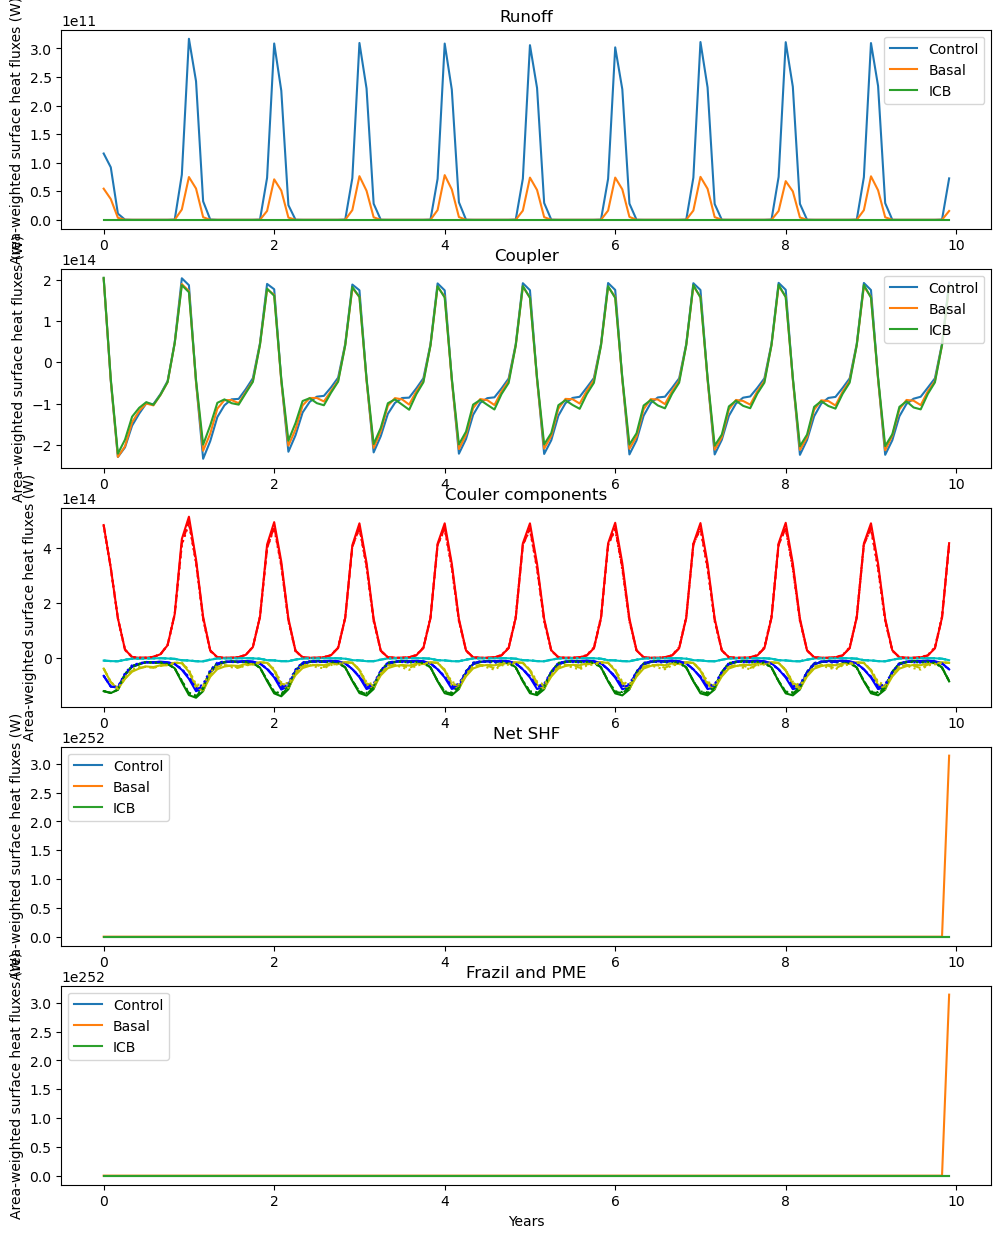

In [25]:
# fig 1: timeseries sfc_hflux_from_runoff area-weighted, averaged horizontally: all years
time = np.arange(0,120)
time_yr = np.divide(time,12)

fig, ax = plt.subplots(nrows=5, figsize = (12, 15))
ax[0].plot(time_yr,HF_runoff_hint_shelf_ctrl, label='Control') # not divided by total area
ax[0].plot(time_yr,HF_runoff_hint_shelf_BG, label='Basal')
ax[0].plot(time_yr,HF_runoff_hint_shelf_ICB, label='ICB')
ax[0].legend()
# ax[0].set_xlabel('Years')
ax[0].set_ylabel('Area-weighted surface heat fluxes (W)')
ax[0].title.set_text('Runoff')

ax[1].plot(time_yr,HF_coupler_hint_shelf_ctrl, label='Control') # not divided by total area
ax[1].plot(time_yr,HF_coupler_hint_shelf_BG, label='Basal')
ax[1].plot(time_yr,HF_coupler_hint_shelf_ICB, label='ICB')
ax[1].legend()
# ax[1].set_xlabel('Years')
ax[1].set_ylabel('Area-weighted surface heat fluxes (W)')
ax[1].title.set_text('Coupler')

# Ctrl
ax[2].plot(time_yr,HF_sw_hint_shelf_ctrl, '-r', label='SW - Control') # not divided by total area
ax[2].plot(time_yr,HF_lw_hint_shelf_ctrl, '-g',label='LW - Control') # not divided by total area
ax[2].plot(time_yr,HF_evap_hint_shelf_ctrl, '-b',label='Latent Heat - Control') # not divided by total area
ax[2].plot(time_yr,HF_sens_hint_shelf_ctrl, '-y',label='Sensible Heat - Control') # not divided by total area
ax[2].plot(time_yr,HF_fprec_hint_shelf_ctrl, '-c',label='F. precip. - Control') # not divided by total area
# BG
ax[2].plot(time_yr,HF_sw_hint_shelf_BG, '--r', label='SW - Basal') # not divided by total area
ax[2].plot(time_yr,HF_lw_hint_shelf_BG, '--g',label='LW - Basal') # not divided by total area
ax[2].plot(time_yr,HF_evap_hint_shelf_BG, '--b',label='Latent Heat - Basal') # not divided by total area
ax[2].plot(time_yr,HF_sens_hint_shelf_BG, '--y',label='Sensible Heat - Basal') # not divided by total area
ax[2].plot(time_yr,HF_fprec_hint_shelf_BG, '--c',label='F. precip. - Basal') # not divided by total area
# ICB
ax[2].plot(time_yr,HF_sw_hint_shelf_ICB, ':r', label='SW - ICB') # not divided by total area
ax[2].plot(time_yr,HF_lw_hint_shelf_ICB, ':g',label='LW - ICB') # not divided by total area
ax[2].plot(time_yr,HF_evap_hint_shelf_ICB, ':b',label='Latent Heat - ICB') # not divided by total area
ax[2].plot(time_yr,HF_sens_hint_shelf_ICB, ':y',label='Sensible Heat - ICB') # not divided by total area
ax[2].plot(time_yr,HF_fprec_hint_shelf_ICB, ':c',label='F. precip. - ICB') # not divided by total area
ax[2].set_ylabel('Area-weighted surface heat fluxes (W)')
ax[2].title.set_text('Couler components')

# calculate NET SHF:
HF_net_hint_shelf_ctrl = HF_runoff_hint_shelf_ctrl+HF_coupler_hint_shelf_ctrl+HF_pme_hint_shelf_ctrl+HF_frazil_hint_shelf_ctrl
HF_net_hint_shelf_BG = HF_runoff_hint_shelf_BG+HF_coupler_hint_shelf_BG+HF_pme_hint_shelf_BG+HF_frazil_hint_shelf_BG+HF_basalmix_hint_shelf_BG+HF_icbmix_hint_shelf_BG
HF_net_hint_shelf_ICB = HF_runoff_hint_shelf_ICB+HF_coupler_hint_shelf_ICB+HF_pme_hint_shelf_ICB+HF_frazil_hint_shelf_ICB+HF_basalmix_hint_shelf_ICB+HF_icbmix_hint_shelf_ICB

ax[3].plot(time_yr,HF_net_hint_shelf_ctrl, label='Control') # not divided by total area
ax[3].plot(time_yr,HF_net_hint_shelf_BG, label='Basal')
ax[3].plot(time_yr,HF_net_hint_shelf_ICB, label='ICB')
ax[3].legend()
# ax[3].set_xlabel('Years')
ax[3].set_ylabel('Area-weighted surface heat fluxes (W)')
ax[3].title.set_text('Net SHF')

ax[4].plot(time_yr,HF_frazil_hint_shelf_ctrl, label='Control') # not divided by total area
ax[4].plot(time_yr,HF_net_hint_shelf_BG, label='Basal')
ax[4].plot(time_yr,HF_net_hint_shelf_ICB, label='ICB')
ax[4].legend()
ax[4].set_xlabel('Years')
ax[4].set_ylabel('Area-weighted surface heat fluxes (W)')
ax[4].title.set_text('Frazil and PME')

### Save fig
plt.savefig(figdir+'Timeseries_SHF_components.png')


Text(0, 0.5, 'Area-weighted surface heat flux \n due to river runoff (W)')

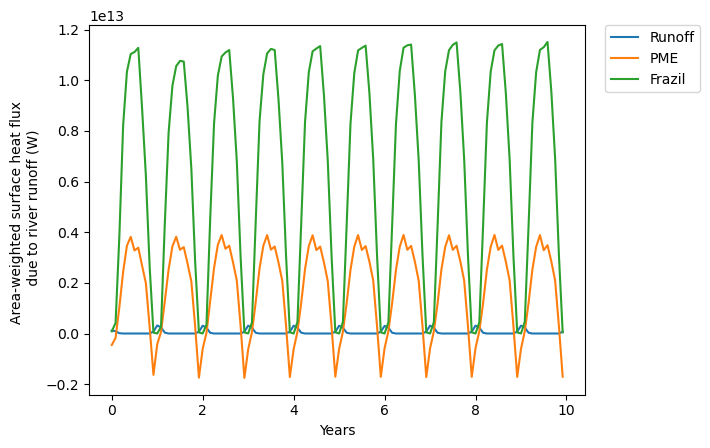

In [26]:

# fig 1: timeseries sfc_hflux_from_runoff area-weighted, averaged horizontally:
time = np.arange(0,120)
time_yr = np.divide(time,12)
plt.plot(time_yr,HF_runoff_hint_shelf_ctrl, label='Runoff') # not divided by total area
# plt.plot(time_yr,HF_coupler_hint_shelf_ctrl, label='Coupler') # not divided by total area
plt.plot(time_yr,HF_pme_hint_shelf_ctrl, label='PME') # not divided by total area
plt.plot(time_yr,HF_frazil_hint_shelf_ctrl, label='Frazil') # not divided by total area
# plt.plot(time_yr,HF_sw_hint_shelf_ctrl, label='Shortwave') # not divided by total area
# plt.plot(time_yr,HF_lw_hint_shelf_ctrl, label='Longwave') # not divided by total area
# plt.plot(time_yr,HF_sens_hint_shelf_ctrl, label='Sensible heat') # not divided by total area
# plt.plot(time_yr,HF_evap_hint_shelf_ctrl, label='Latent heat') # not divided by total area
# plt.plot(time_yr,HF_fprec_hint_shelf_ctrl, label='Melt of frozen prec.') # not divided by total area

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel('Years')
plt.ylabel('Area-weighted surface heat flux \n due to river runoff (W)')

Text(0, 0.5, 'Area-weighted surface heat flux \n due to river runoff (W)')

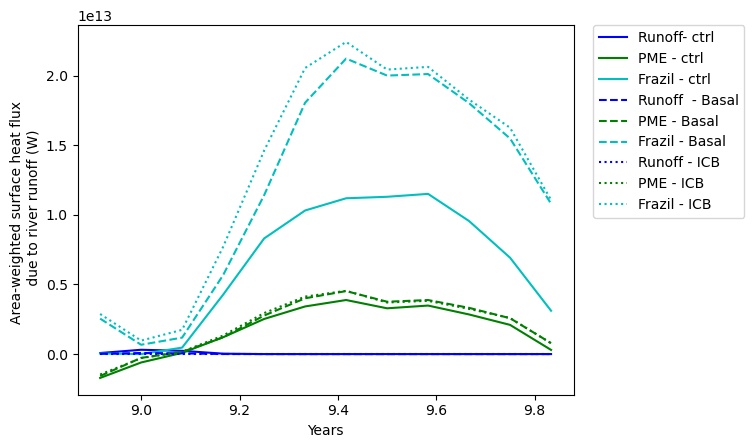

In [27]:
# fig 1: timeseries sfc_hflux_from_runoff area-weighted, averaged horizontally:
time = np.arange(0,120)
time_yr = np.divide(time,12)
plt.plot(time_yr[107:-1],HF_runoff_hint_shelf_ctrl[107:-1], label='Runoff- ctrl',color='b', linestyle='-') # not divided by total area
plt.plot(time_yr[107:-1],HF_pme_hint_shelf_ctrl[107:-1], label='PME - ctrl',color='g', linestyle='-') # not divided by total area
plt.plot(time_yr[107:-1],HF_frazil_hint_shelf_ctrl[107:-1], label='Frazil - ctrl',color='c', linestyle='-') # not divided by total area
plt.plot(time_yr[107:-1],HF_runoff_hint_shelf_BG[107:-1], label='Runoff  - Basal',color='b', linestyle='--') # not divided by total area
plt.plot(time_yr[107:-1],HF_pme_hint_shelf_BG[107:-1], label='PME - Basal',color='g', linestyle='--') # not divided by total area
plt.plot(time_yr[107:-1],HF_frazil_hint_shelf_BG[107:-1], label='Frazil - Basal',color='c', linestyle='--') # not divided by total area
plt.plot(time_yr[107:-1],HF_runoff_hint_shelf_ICB[107:-1], label='Runoff - ICB',color='b', linestyle=':') # not divided by total area
plt.plot(time_yr[107:-1],HF_pme_hint_shelf_ICB[107:-1], label='PME - ICB',color='g', linestyle=':') # not divided by total area
plt.plot(time_yr[107:-1],HF_frazil_hint_shelf_ICB[107:-1], label='Frazil - ICB',color='c', linestyle=':') # not divided by total area


plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel('Years')
plt.ylabel('Area-weighted surface heat flux \n due to river runoff (W)')

Text(0, 0.5, 'Area-weighted surface heat flux \n due to river runoff (W)')

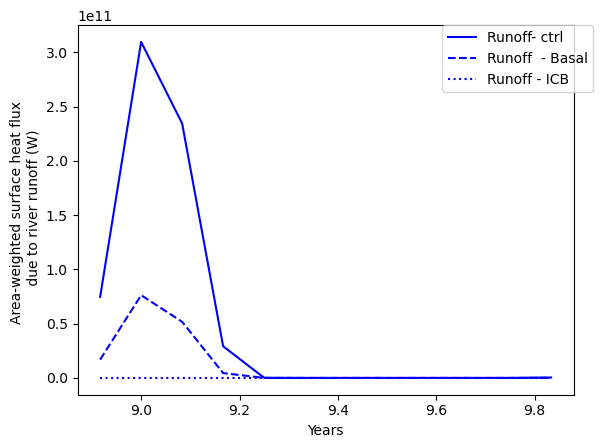

In [28]:
# fig 1: timeseries sfc_hflux_from_runoff area-weighted, averaged horizontally:
time = np.arange(0,120)
time_yr = np.divide(time,12)
plt.plot(time_yr[107:-1],HF_runoff_hint_shelf_ctrl[107:-1], label='Runoff- ctrl',color='b', linestyle='-') # not divided by total area
plt.plot(time_yr[107:-1],HF_runoff_hint_shelf_BG[107:-1], label='Runoff  - Basal',color='b', linestyle='--') # not divided by total area
plt.plot(time_yr[107:-1],HF_runoff_hint_shelf_ICB[107:-1], label='Runoff - ICB',color='b', linestyle=':') # not divided by total area

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel('Years')
plt.ylabel('Area-weighted surface heat flux \n due to river runoff (W)')

In [29]:
time_yr[107:-1].shape

(12,)